# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from time import sleep
from collections import deque
from ddpg_agent import Agent
%matplotlib inline

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [2]:
############################################################
env = UnityEnvironment(file_name='Reacher20.app')
# Environments contain brains which are responsible for deciding the actions of their associated agents
# Here we check for the first brain available, and set it as the default brain 
# that we will be controlling from Python.
brain_name = env.brain_names[0]
brain = env.brains[brain_name]                    # get the default brain

############################################################
env_info = env.reset(train_mode=True)[brain_name] 
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = brain.vector_observation_space_size
states = env_info.vector_observations

print('Shape of states: {}'.format(states.shape))

print('Number of agents:', num_agents)
print('Size of each action:', action_size)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

agent = Agent(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=42)
env_info = env.reset(train_mode=True)[brain_name] 

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Shape of states: (20, 33)
Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
NOISE: <ddpg_agent.OUNoise object at 0x11ffff438>


### 3. Train the Agent

/Users/andy.gooden/.pyenv/versions/3.6.15/envs/p1_navigation/lib/python3.6/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


STARTING RUN: id 2746317214
Episode 5	Average Score: 1.02	Score Variance: 0.15
Episode 10	Average Score: 1.50	Score Variance: 0.24
Episode 15	Average Score: 3.92	Score Variance: 0.99
Episode 20	Average Score: 12.11	Score Variance: 8.92
Episode 25	Average Score: 19.66	Score Variance: 36.40
Episode 30	Average Score: 26.37	Score Variance: 73.62
Episode 35	Average Score: 35.06	Score Variance: 132.44
Episode 40	Average Score: 38.05	Score Variance: 190.19
Episode 45	Average Score: 38.57	Score Variance: 225.91
Episode 50	Average Score: 39.12	Score Variance: 244.56
Saving model params as: 2746317214_checkpoint_actor.pth and 2746317214_checkpoint_critic.pth
Episode 55	Average Score: 38.95	Score Variance: 252.72
Episode 60	Average Score: 36.70	Score Variance: 251.64
Episode 65	Average Score: 38.02	Score Variance: 247.99
Episode 70	Average Score: 37.85	Score Variance: 242.71
Episode 75	Average Score: 37.93	Score Variance: 236.60
Episode 80	Average Score: 37.68	Score Variance: 230.61
Episode 85	Av

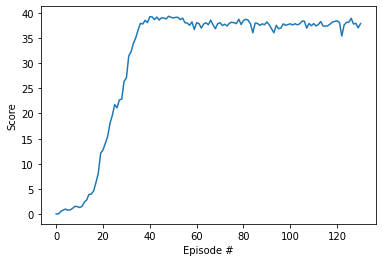

In [3]:
def ddpg(run_id="1", n_episodes=3000, max_t=500):
    """Deep Deterministic Policy Gradient
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    Constants
    ======
        AVE_SCORE_TARGET (int): the average of scores in SCORE_WINDOW, above which we consider the problem solved
        SCORE_WINDOW_SIZE (int): number of scores to average over
    """
    SCORE_WINDOW_SIZE = 100
    AVE_SCORE_TARGET = 30.0
    solved = False                                         # do we have a solution yet?
    best_score = 0                                         # what's our best average score?
    break_on_first_solution = True                        # bail as soon as we meet criteria?
    scores = []                                            # list containing scores from each episode
    variances = []                                         # I want to see the variance of scores in score wind
    scores_window = deque(maxlen=SCORE_WINDOW_SIZE)        # last 100 scores
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations              # get current states from all agents (N,33)
        agent.reset()                                      # reset exploratory noise on agent
        score = 0
        t = 0
        while True:
        #for t in range(max_t):
            actions = agent.act(states)                      # get actions to take (N,4)
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations   # get next state for each agent (N,33)
            rewards = env_info.rewards                   # get the rewards (N,)
            dones = env_info.local_done                  # see if episode has finished (N,)
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += np.mean(rewards)
            t += 1
            if any(dones):
                #print(f"Episode {i_episode} took {t} steps")
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore Variance: {:.2f}'.format(i_episode, scores_window[-1], np.var(scores_window)), end="")
        if i_episode % 5 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, scores_window[-1]))
            
        if all(np.array(scores_window) >= AVE_SCORE_TARGET):
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\tScore Variance: {:.2f}'.format(i_episode, scores_window[-1], np.var(scores_window)))
            agent.save_policy(f'final_{run_id}')
            break
            
        if i_episode % 50 == 0:
            agent.save_policy(run_id)
    return scores

st = time.time()
run_id = str(random.randint(1, 2**32-1))
print(f"STARTING RUN: id {run_id}")
scores = ddpg(run_id=run_id)
print("\n\ntotal train time: ", time.time() - st)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.